# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO (PRE-COVID)
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [14]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2019-01-01'
fecha_inicio_test = '2019-01-02'
fecha_fin_test = '2019-06-01'

Obtenemos los datos de train

In [15]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [16]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [17]:
scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(2142, 1) (2264, 1) (1567, 1) (2262, 1)


Definimos una función para crear datos de train y test

In [18]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [19]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [20]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [21]:
def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [22]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:11], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:10], label=name, color='blue')
    ax.set_title(name)

In [23]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

In [24]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [25]:
pasos = 2 # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [26]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  0.609839227717639
MSE:  0.3719038836632463
MAE:  0.42741366746287546
R²:  0.9422892279883178


SP500 (^GSPC)
RMSE:  21.53021579647729
MSE:  463.55019224288026
MAE:  15.947908461423848
R²:  0.9601479473202061


Bitcoin (BTC-USD)
RMSE:  191.67906476554077
MSE:  36740.86386939238
MAE:  105.45311569318183
R²:  0.9828324749604613


Petroleo (CL=F)
RMSE:  1.007467424751299
MSE:  1.0149906119350143
MAE:  0.7609222206106879
R²:  0.9518089370217554




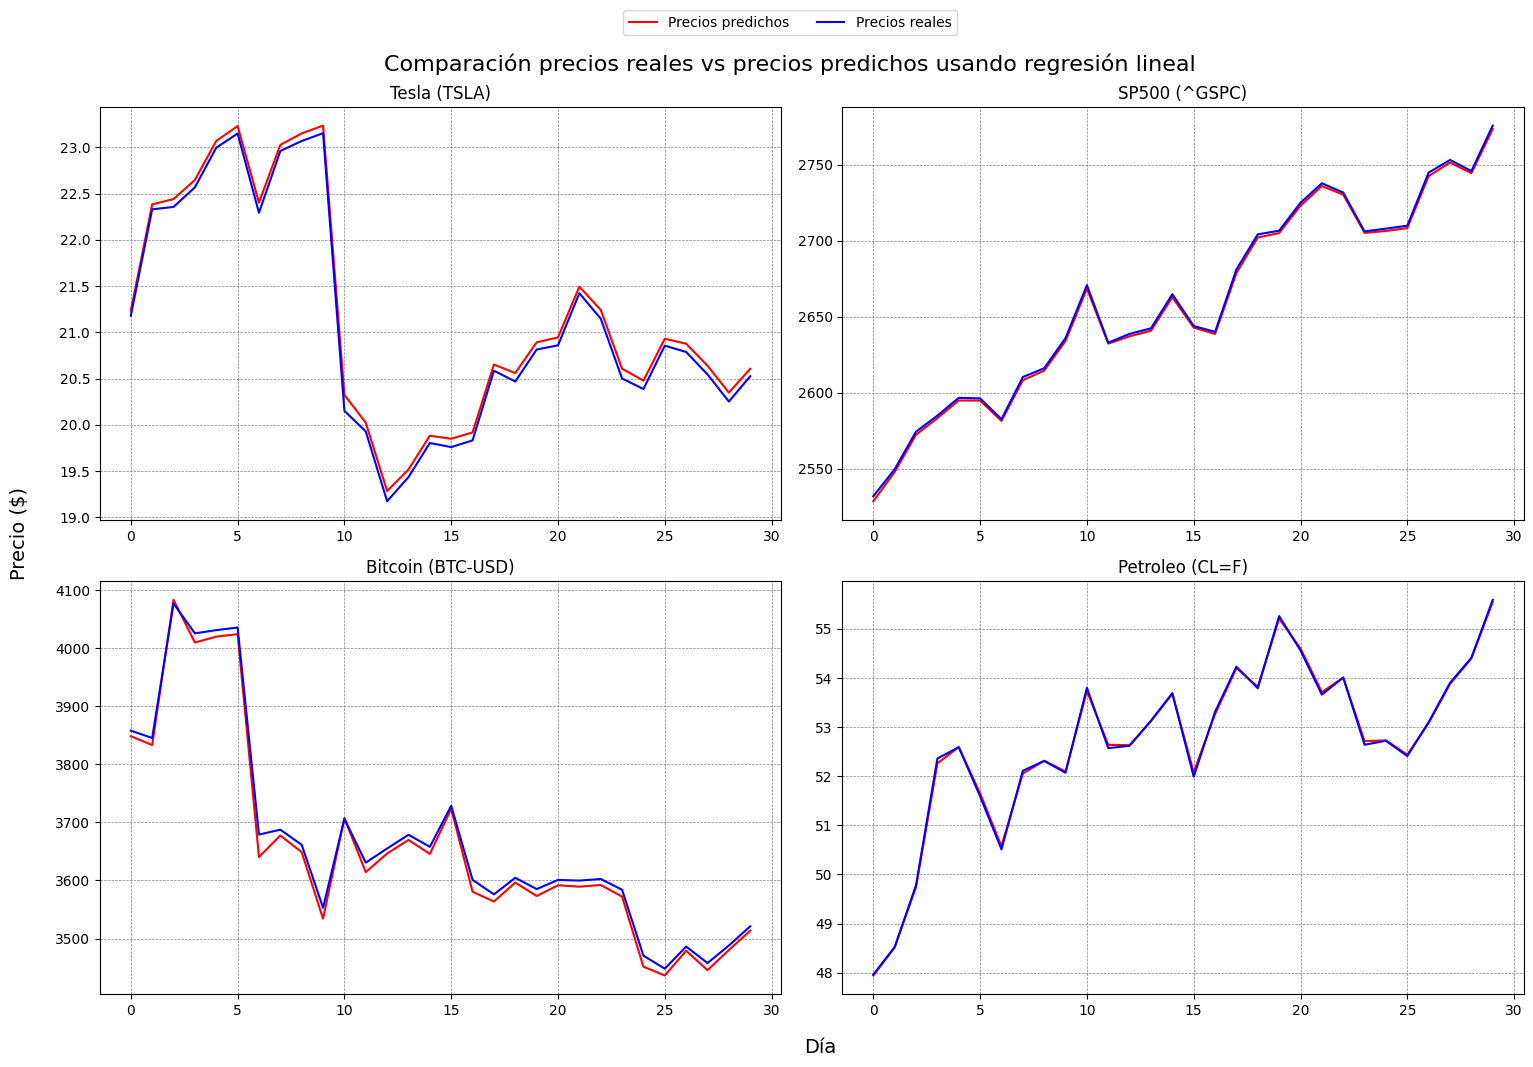

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  1.9895869239768513
MSE:  3.9584561280596695
MAE:  1.9067334215264522
R²:  -44.48293661904296


SP500 (^GSPC)
RMSE:  163.21982004542198
MSE:  26640.70965565993
MAE:  158.00597919345088
R²:  -1254.146468589846


Bitcoin (BTC-USD)
RMSE:  165.275530428235
MSE:  27316.000958334433
MAE:  128.59679776056365
R²:  -15.349652069224224


Petroleo (CL=F)
RMSE:  4.464567405290319
MSE:  19.93236211638073
MAE:  4.149085830650645
R²:  -4144.658847194961




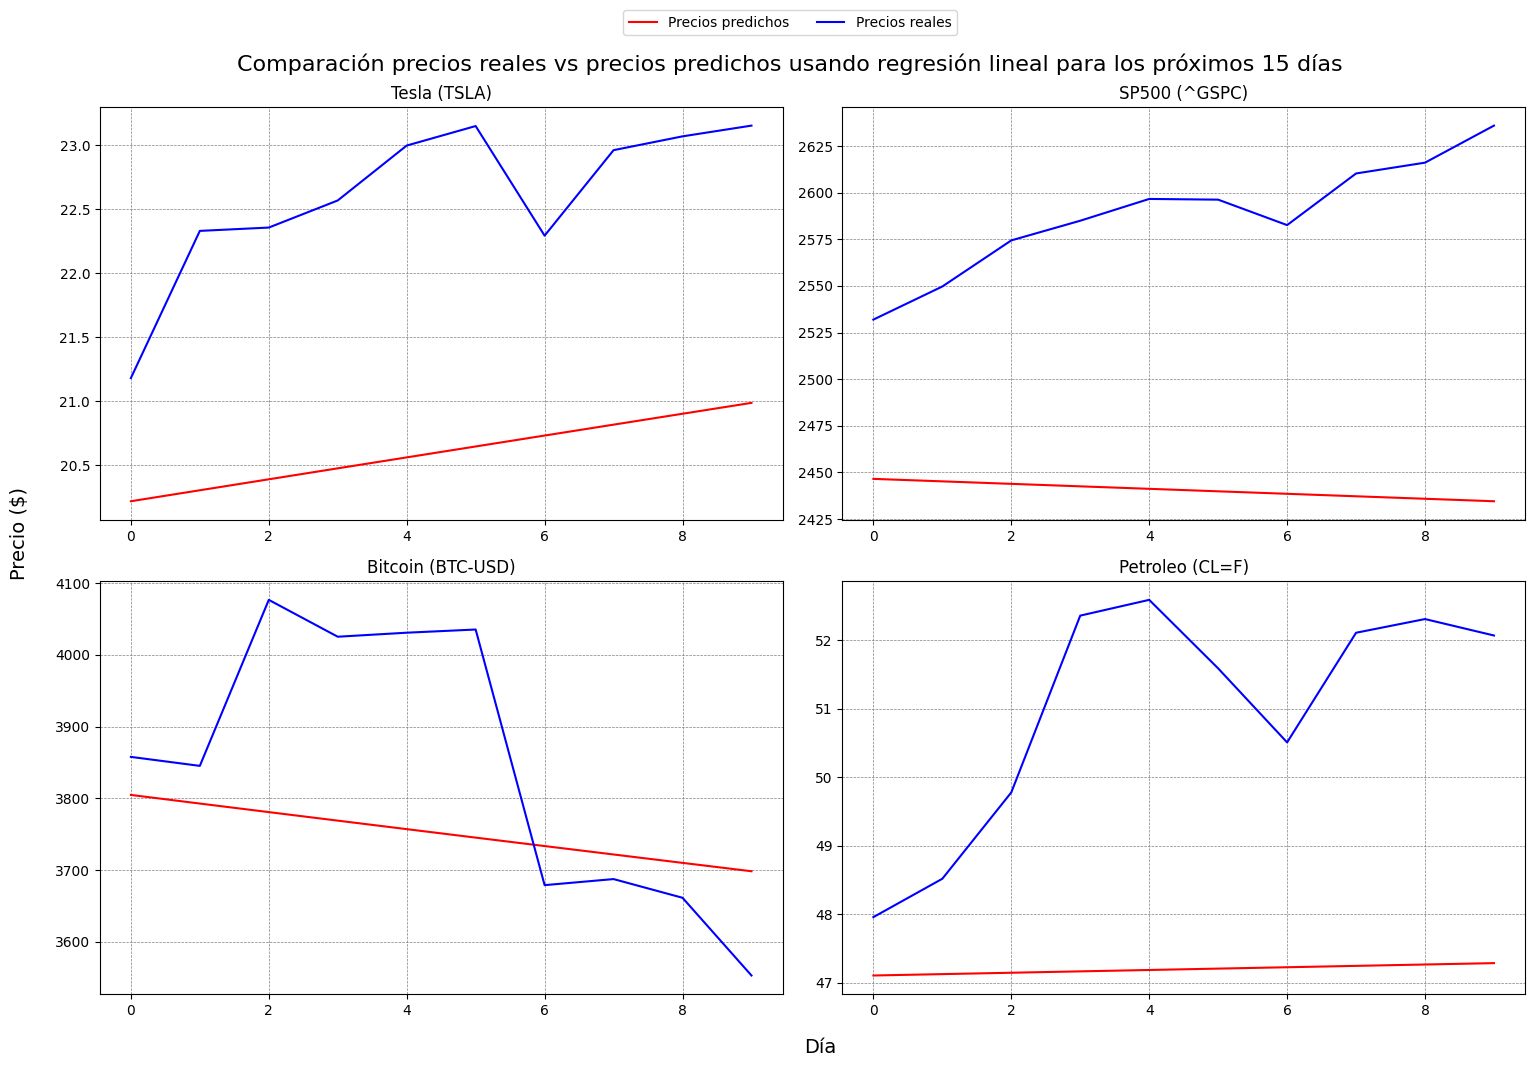

In [28]:
ventana = pasos
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [29]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 35
pasos_sp500 = 35
pasos_bitcoin = 50
pasos_petroleo = 20

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [30]:
param_grid = {'C': [1, 10, 100, 200, 300, 500, 600, 800, 1000, 1500, 2000, 3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 
              'gamma': [1, 0.1, 0.2, 0.4, 0.8, 0.001,0.002,0.004,0.006, 0.0008, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 
              'kernel': ['linear', 'rbf']}

model_svr_tesla = SVR()
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

print("Mejores parámetros para Tesla: ", grid_search.best_params_)
print("Mejor resultado para Tesla: ", grid_search.best_score_)


model_svr_sp500 = SVR()
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

print("Mejores parámetros para SP500: ", grid_search.best_params_)
print("Mejor resultado para SP500: ", grid_search.best_score_)


model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)


model_svr_petroleo = SVR()
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

print("Mejores parámetros para Petróleo: ", grid_search.best_params_)
print("Mejor resultado para Petróleo: ", grid_search.best_score_)

Mejores parámetros para Tesla:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Mejor resultado para Tesla:  0.9850859388308585
Mejores parámetros para SP500:  {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Mejor resultado para SP500:  0.9871615508850881
Mejores parámetros para Bitcoin:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Mejor resultado para Bitcoin:  0.8590229786147701
Mejores parámetros para Petróleo:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Mejor resultado para Petróleo:  0.9851244035983383


In [31]:
model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)

Mejores parámetros para Bitcoin:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Mejor resultado para Bitcoin:  0.8590229786147701


Tesla (TSLA)
RMSE:  4.447148803353729
MSE:  19.777132479170504
MAE:  4.391690644777868
R²:  -4.95469563418112


SP500 (^GSPC)
RMSE:  215.06979647984548
MSE:  46255.017357882156
MAE:  210.39953092841608
R²:  -14.582759953775026


Bitcoin (BTC-USD)
RMSE:  598.4799025056303
MSE:  358178.19370314875
MAE:  513.6944483999148
R²:  0.8218303210986242


Petroleo (CL=F)
RMSE:  1.4918505636236723
MSE:  2.2256181041842686
MAE:  1.1044780070922762
R²:  0.8217961525582198




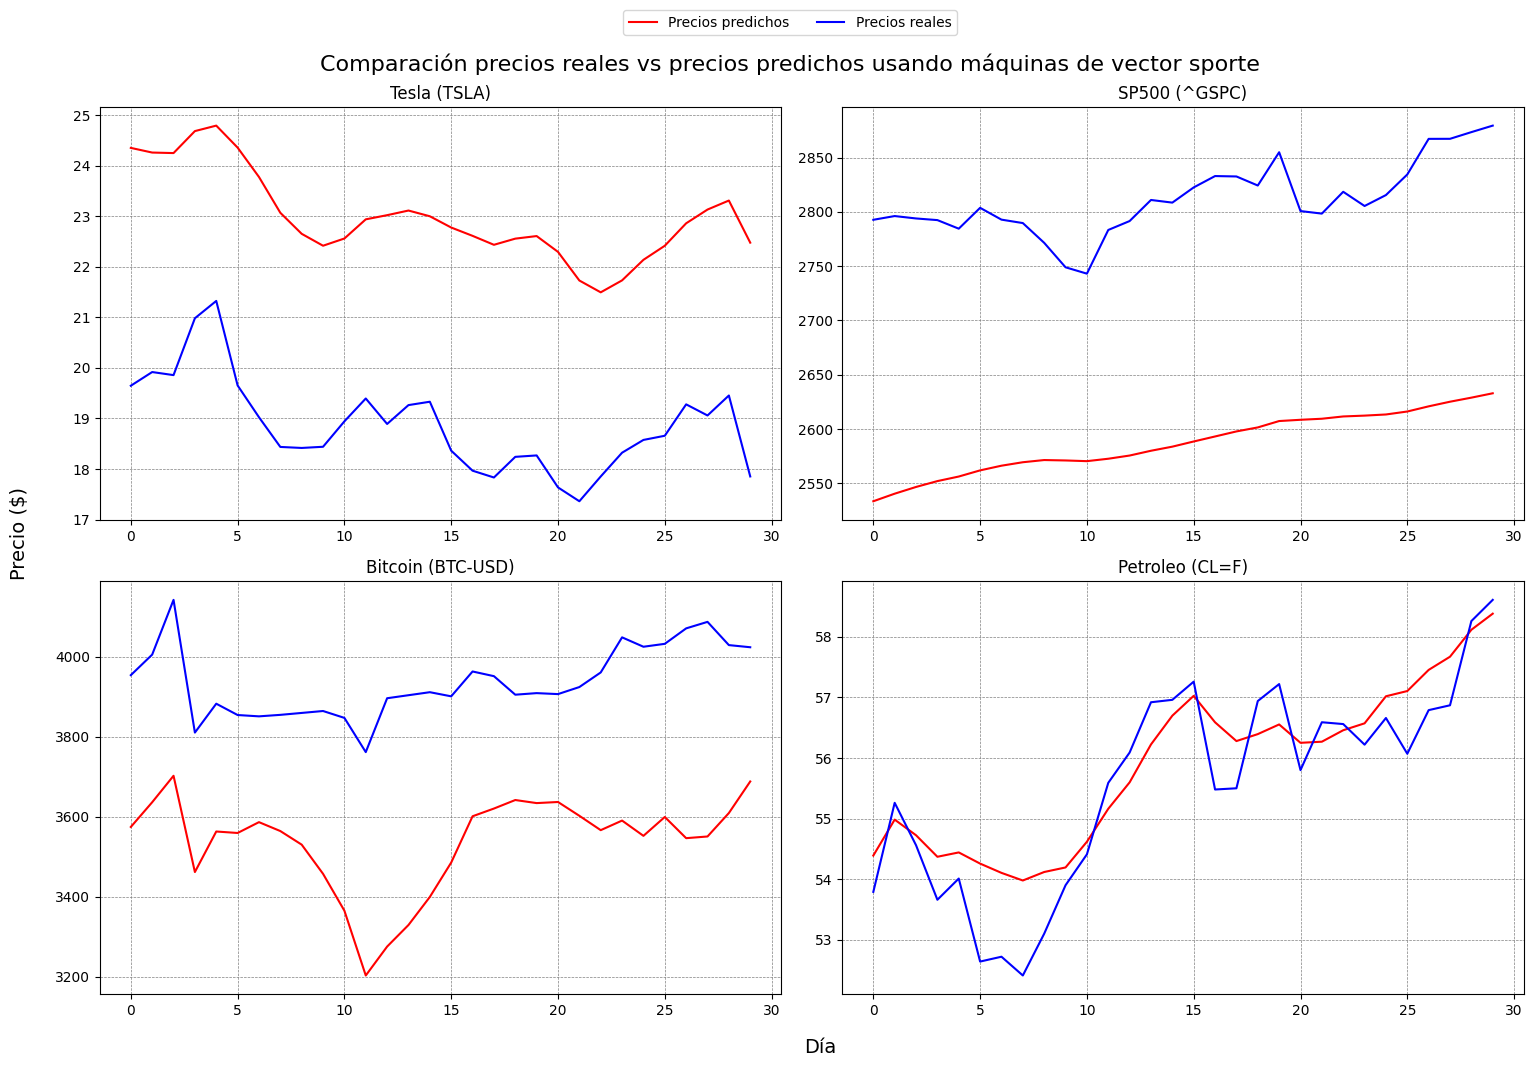

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

    El modelo es demasiado simple o no es adecuado para los datos, lo que significa que no es capaz de capturar la complejidad de la relación entre las variables predictoras y la variable objetivo.

    Las características (variables predictoras) que se están utilizando no son relevantes para predecir la variable objetivo.

    La variable objetivo tiene demasiado ruido o variabilidad, lo que hace que sea difícil de predecir.

    El modelo se ha sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos.

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  11.19075998761022
MSE:  125.23310910029788
MAE:  10.69947716837761
R²:  -15.638911988378755


SP500 (^GSPC)
RMSE:  326.69044765551416
MSE:  106726.64858936022
MAE:  324.9498690802621
R²:  -57.816646082028456


Bitcoin (BTC-USD)
RMSE:  2188.1747965681475
MSE:  4788108.940336053
MAE:  1908.3632589784636
R²:  -2.744714233225652


Petroleo (CL=F)
RMSE:  1.6489312927045472
MSE:  2.7189744080602893
MAE:  1.3669289321779097
R²:  -9.619481206921966




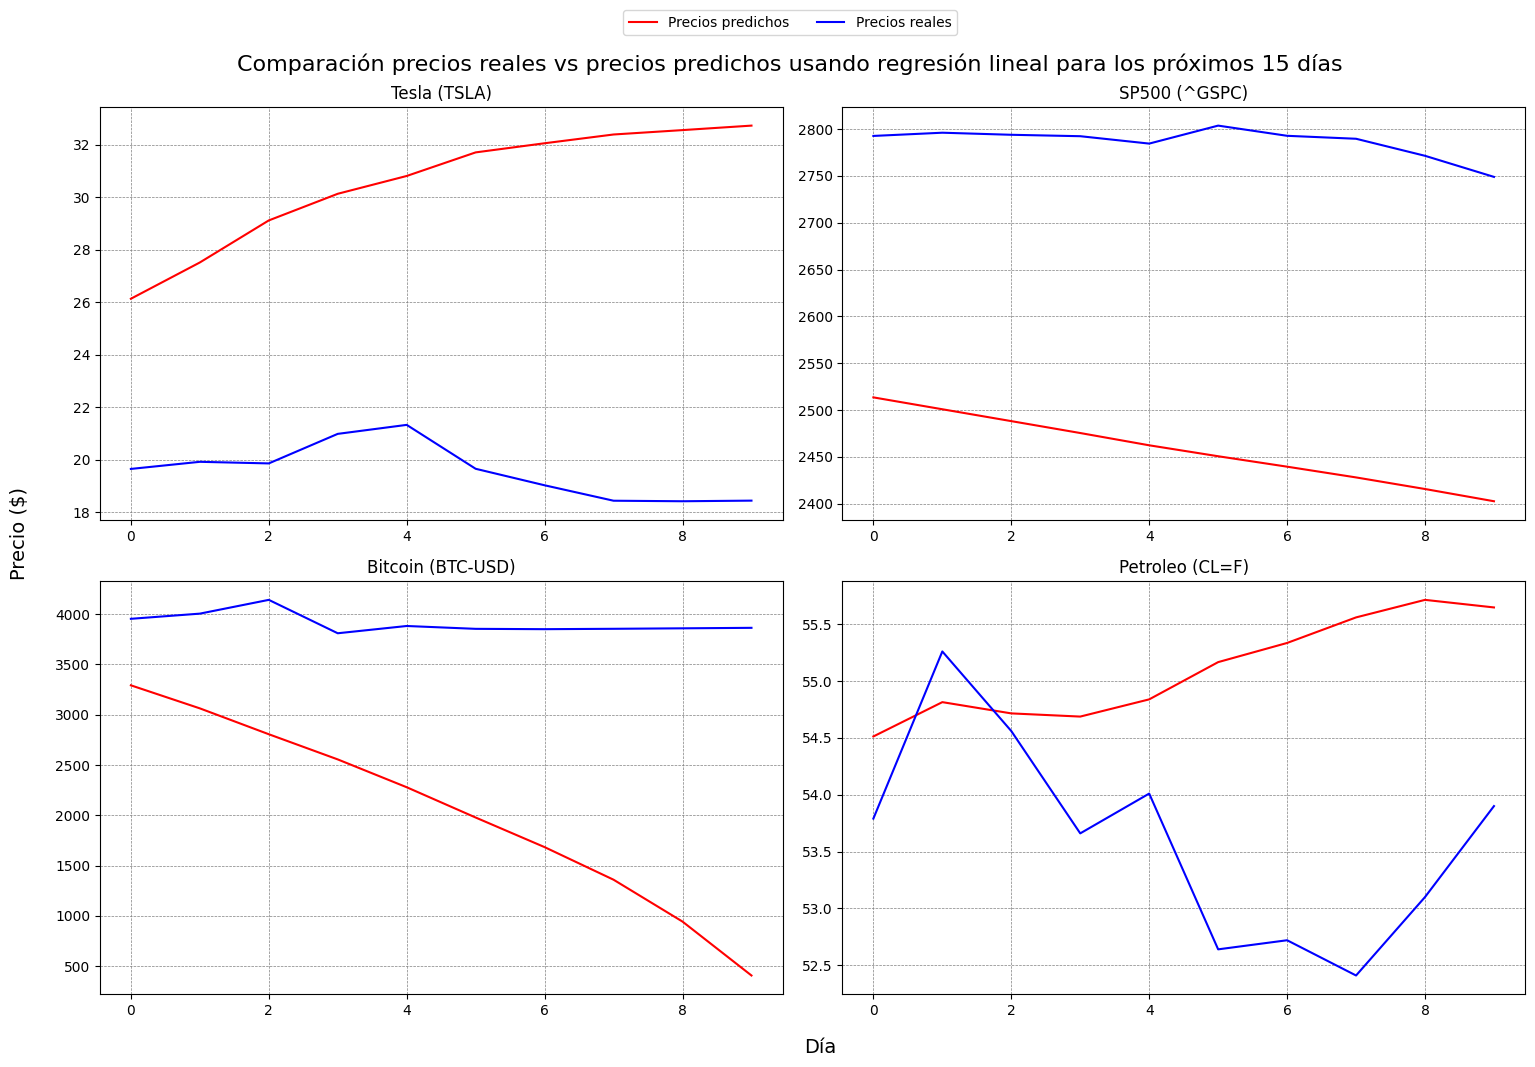

In [33]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [34]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 50
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [35]:
def create_lstm(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_tesla = KerasRegressor(build_fn=create_lstm)
lstm_sp500 = KerasRegressor(build_fn=create_lstm)
lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
lstm_petroleo = KerasRegressor(build_fn=create_lstm)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=lstm_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=lstm_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=lstm_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=lstm_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\2567794457.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_tesla = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\2567794457.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_sp500 = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\2567794457.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Na

70/70 [==============================] - 4s 33ms/step - loss: 0.0246
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9836918832219216
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.9916182014972978
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.9652472744608586
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 256}
Mejor resultado para Petróleo:  0.9792364035606486


3/3 [==============================] - 0s 6ms/step
Tesla (TSLA)
RMSE:  1.7277761161459027
MSE:  2.98521030752422
MAE:  1.5942654738555084
R²:  0.034061980769566236


3/3 [==============================] - 0s 6ms/step
SP500 (^GSPC)
RMSE:  2441.915235176039
MSE:  5962950.01578485
MAE:  2437.9222775021117
R²:  -201.38897917339844


4/4 [==============================] - 0s 22ms/step
Bitcoin (BTC-USD)
RMSE:  17559.644920183902
MSE:  308341129.7229404
MAE:  14546.624639892578
R²:  -0.1412715335740231


3/3 [==============================] - 0s 6ms/step
Petroleo (CL=F)
RMSE:  0.9929714698769126
MSE:  0.9859923399895165
MAE:  0.7260405050741661
R²:  0.9028976833227795




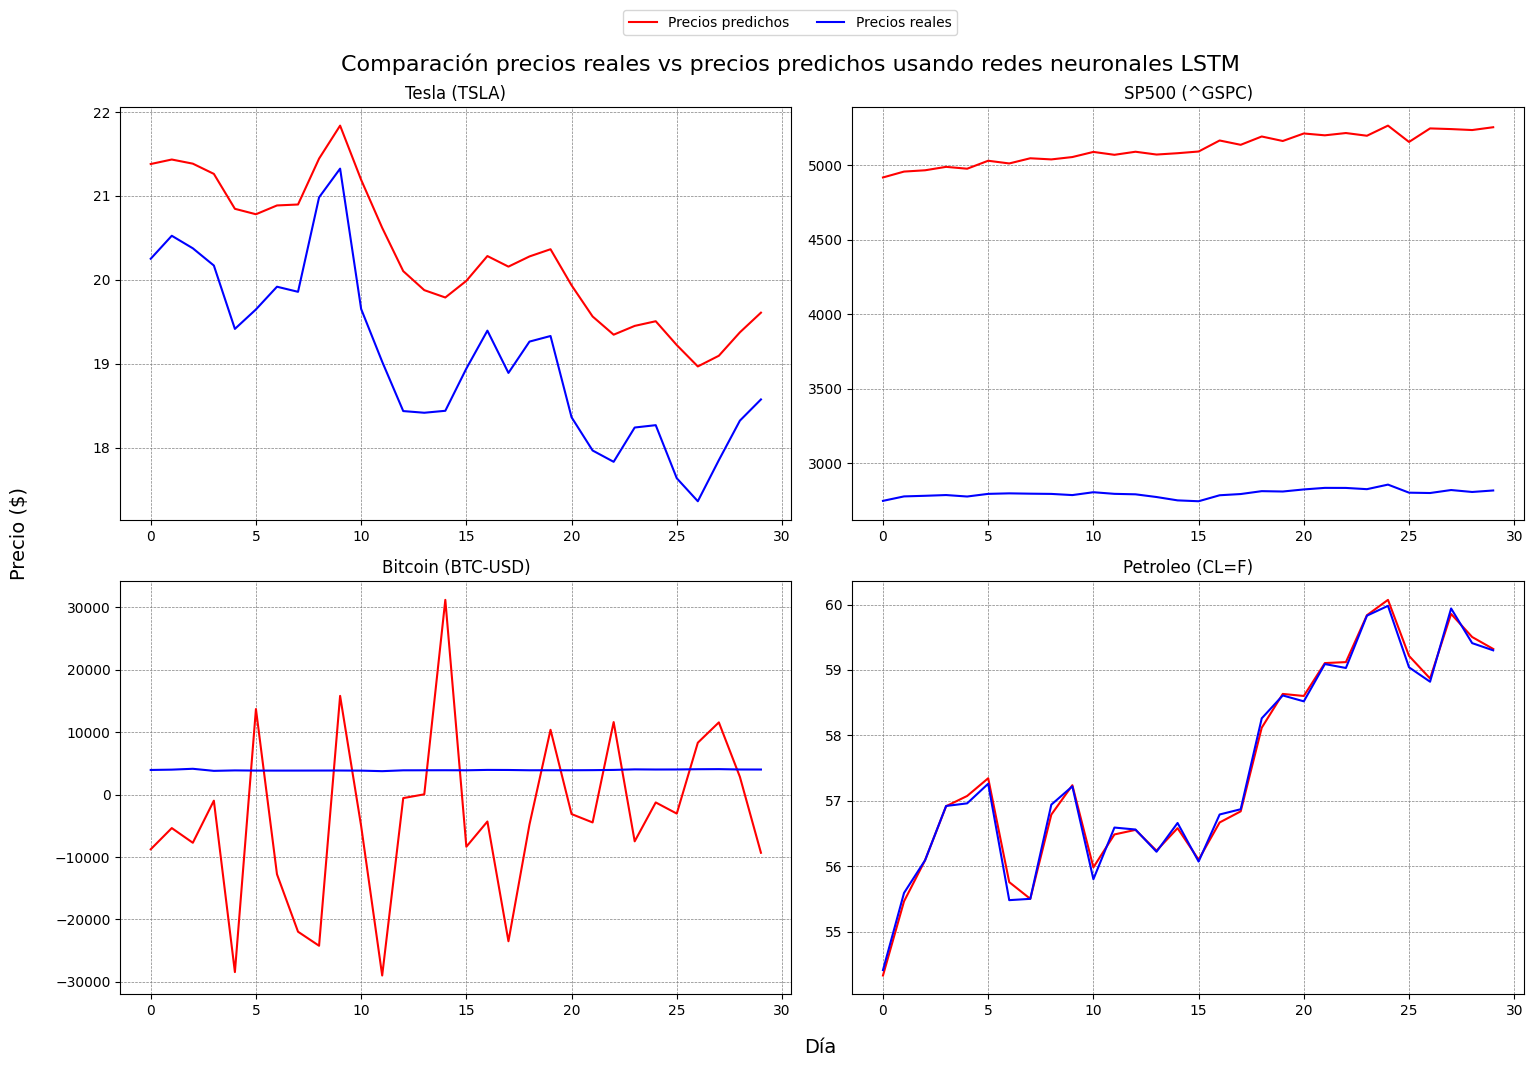

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_tesla.add(Dense(units = 1))

lstm_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_tesla, 'lstm_tesla.h5')


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_sp500.add(Dense(units = 1))
lstm_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_sp500, 'lstm_sp500.h5')


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_bitcoin.add(Dense(units = 1))
lstm_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_bitcoin, 'lstm_bitcoin.h5')


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_petroleo.add(Dense(units = 1))
lstm_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_petroleo, 'lstm_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  3.612743419869118
MSE:  13.05191501780761
MAE:  3.368354320526123
R²:  -10.987972898281997


SP500 (^GSPC)
RMSE:  17414.03482222653
MSE:  303248608.78971815
MAE:  15405.708821614584
R²:  -3.588561451567897


Bitcoin (BTC-USD)
RMSE:  21268.694051012004
MSE:  452357346.6355534
MAE:  19537.22001139323
R²:  -1.7636020099839205


Petroleo (CL=F)
RMSE:  2.824357583597444
MSE:  7.976995760024393
MAE:  2.6736329396565766
R²:  -388.3800974951684




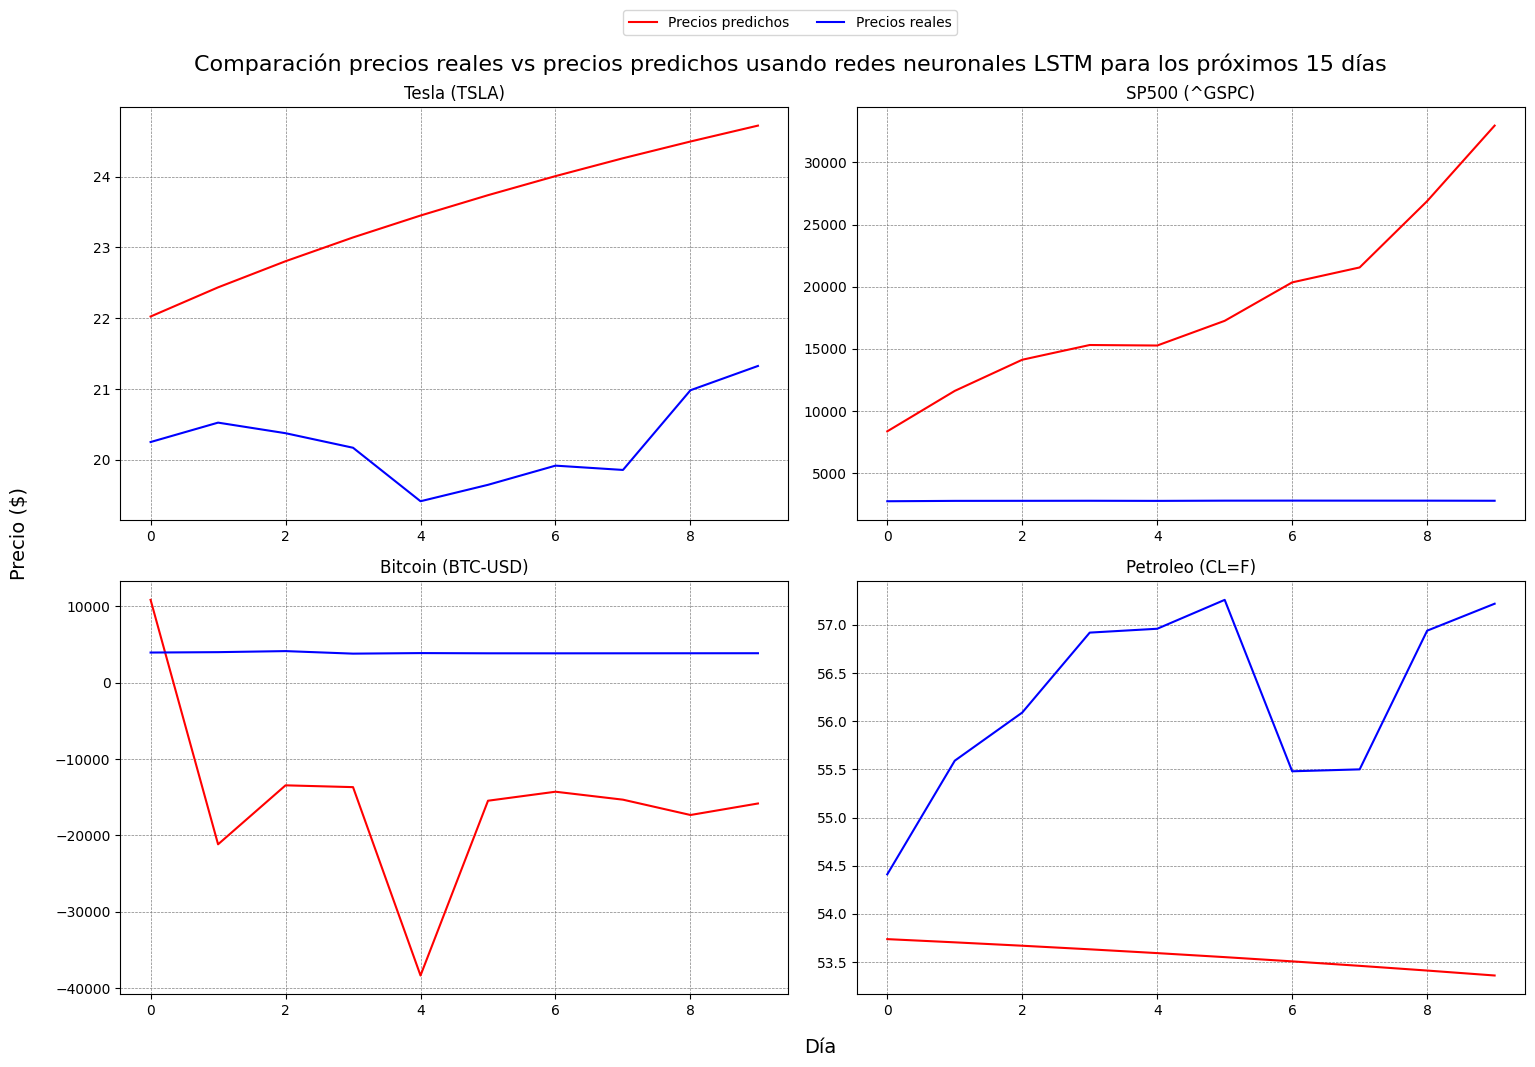

In [37]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# GRU

In [38]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 35
pasos_sp500 = 35
pasos_bitcoin = 50
pasos_petroleo = 20

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

In [39]:
def create_gru(units, activation):
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_tesla = KerasRegressor(build_fn=create_gru)
gru_sp500 = KerasRegressor(build_fn=create_gru)
gru_bitcoin = KerasRegressor(build_fn=create_gru)
gru_petroleo = KerasRegressor(build_fn=create_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\3894157762.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_tesla = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\3894157762.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_sp500 = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\3894157762.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_bitcoin = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\App

71/71 [==============================] - 3s 30ms/step - loss: 0.0257
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9929917937653777
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.9931569602551068
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.9742228898434925
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.9864923266672504


3/3 [==============================] - 0s 7ms/step
Tesla (TSLA)
RMSE:  5.954523341351864
MSE:  35.45634822270417
MAE:  5.7452244965926464
R²:  -87.3187369006583


3/3 [==============================] - 0s 6ms/step
SP500 (^GSPC)
RMSE:  68.00797799082842
MSE:  4625.085070401004
MAE:  65.16019870923915
R²:  -0.6355971225509851


4/4 [==============================] - 0s 18ms/step
Bitcoin (BTC-USD)
RMSE:  1081.1326347134611
MSE:  1168847.77384247
MAE:  1004.0521069335938
R²:  0.2856843297675835


3/3 [==============================] - 0s 7ms/step
Petroleo (CL=F)
RMSE:  0.9823121541635808
MSE:  0.9649371682174945
MAE:  0.7194095793224519
R²:  0.9302507254412793




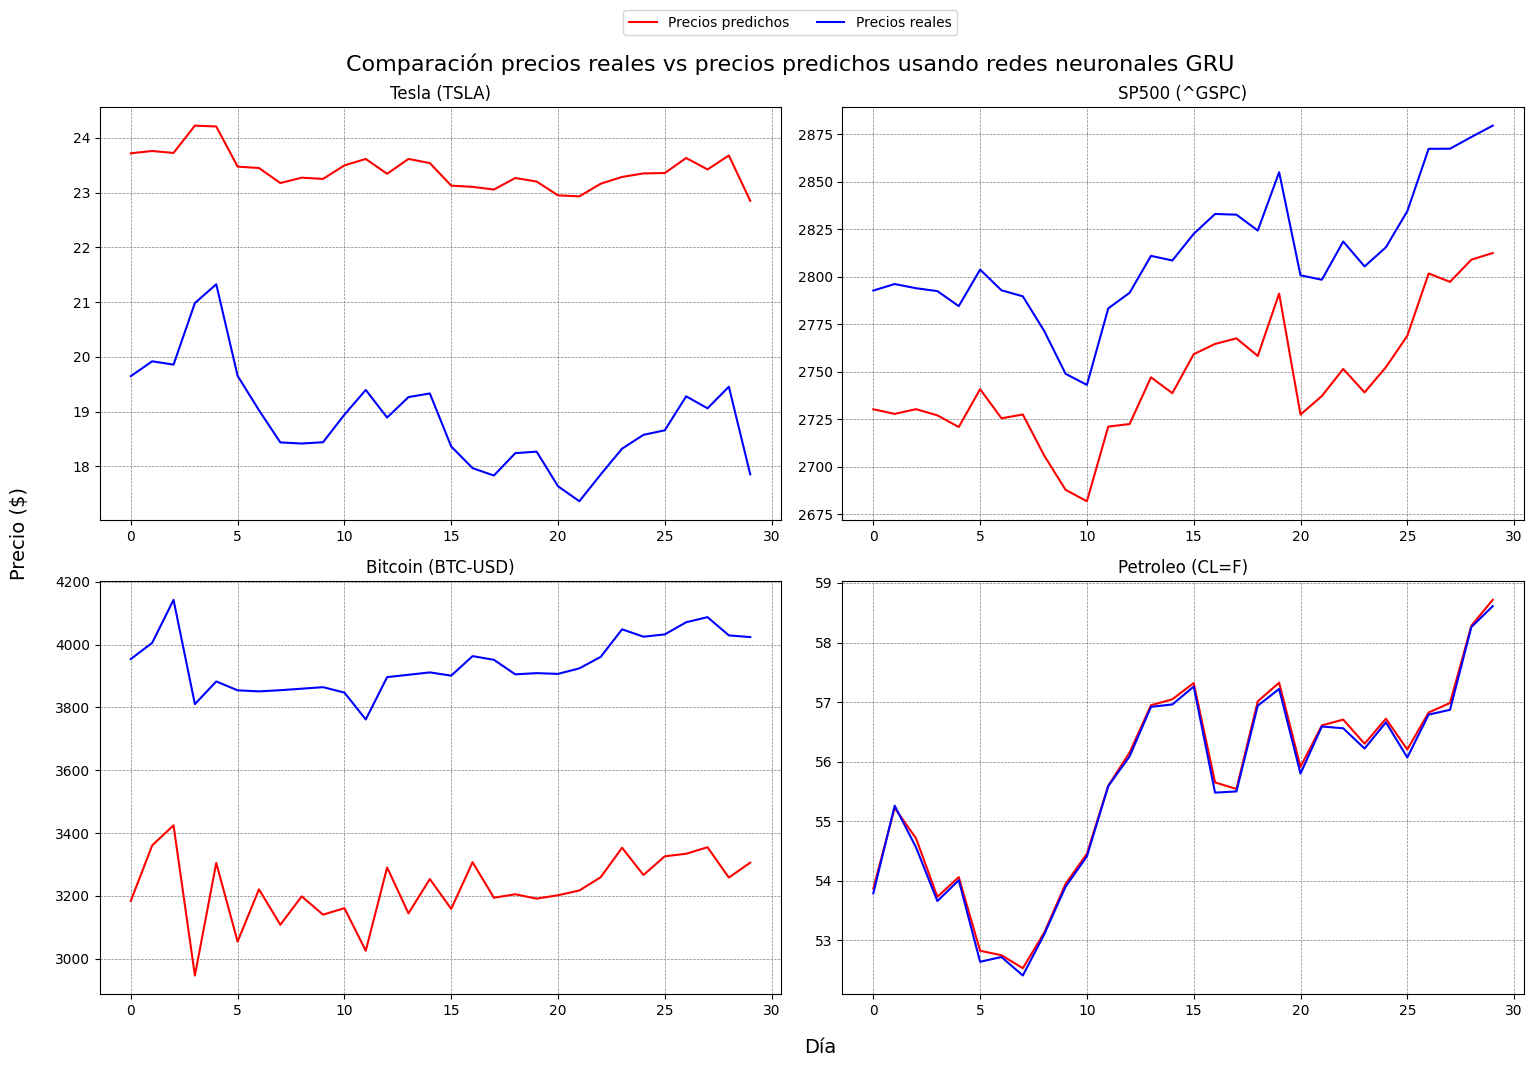

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = Sequential()
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
gru_tesla.add(Dense(units = 1))

gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(gru_tesla, 'gru_tesla.h5')



gru_sp500 = Sequential()
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
gru_sp500.add(Dense(units = 1))
gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(gru_sp500, 'gru_sp500.h5')


gru_bitcoin = Sequential()
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
gru_bitcoin.add(Dense(units = 1))
gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(gru_bitcoin, 'gru_bitcoin.h5')

gru_petroleo = Sequential()
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
gru_petroleo.add(Dense(units = 1))
gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(gru_petroleo, 'gru_petroleo.h5')

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  6.920333480320808
MSE:  47.89101547884911
MAE:  6.7617119153340655
R²:  -53.419139186635654


SP500 (^GSPC)
RMSE:  427.8838305783089
MSE:  183084.57247036695
MAE:  389.0229899088542
R²:  -4.095762166561455


Bitcoin (BTC-USD)
RMSE:  3239.260924268668
MSE:  10492811.335493905
MAE:  3083.966605504354
R²:  -8.521066691469418


Petroleo (CL=F)
RMSE:  1.3065848643123565
MSE:  1.7071640076501389
MAE:  1.1013123194376646
R²:  -27.63011889690151




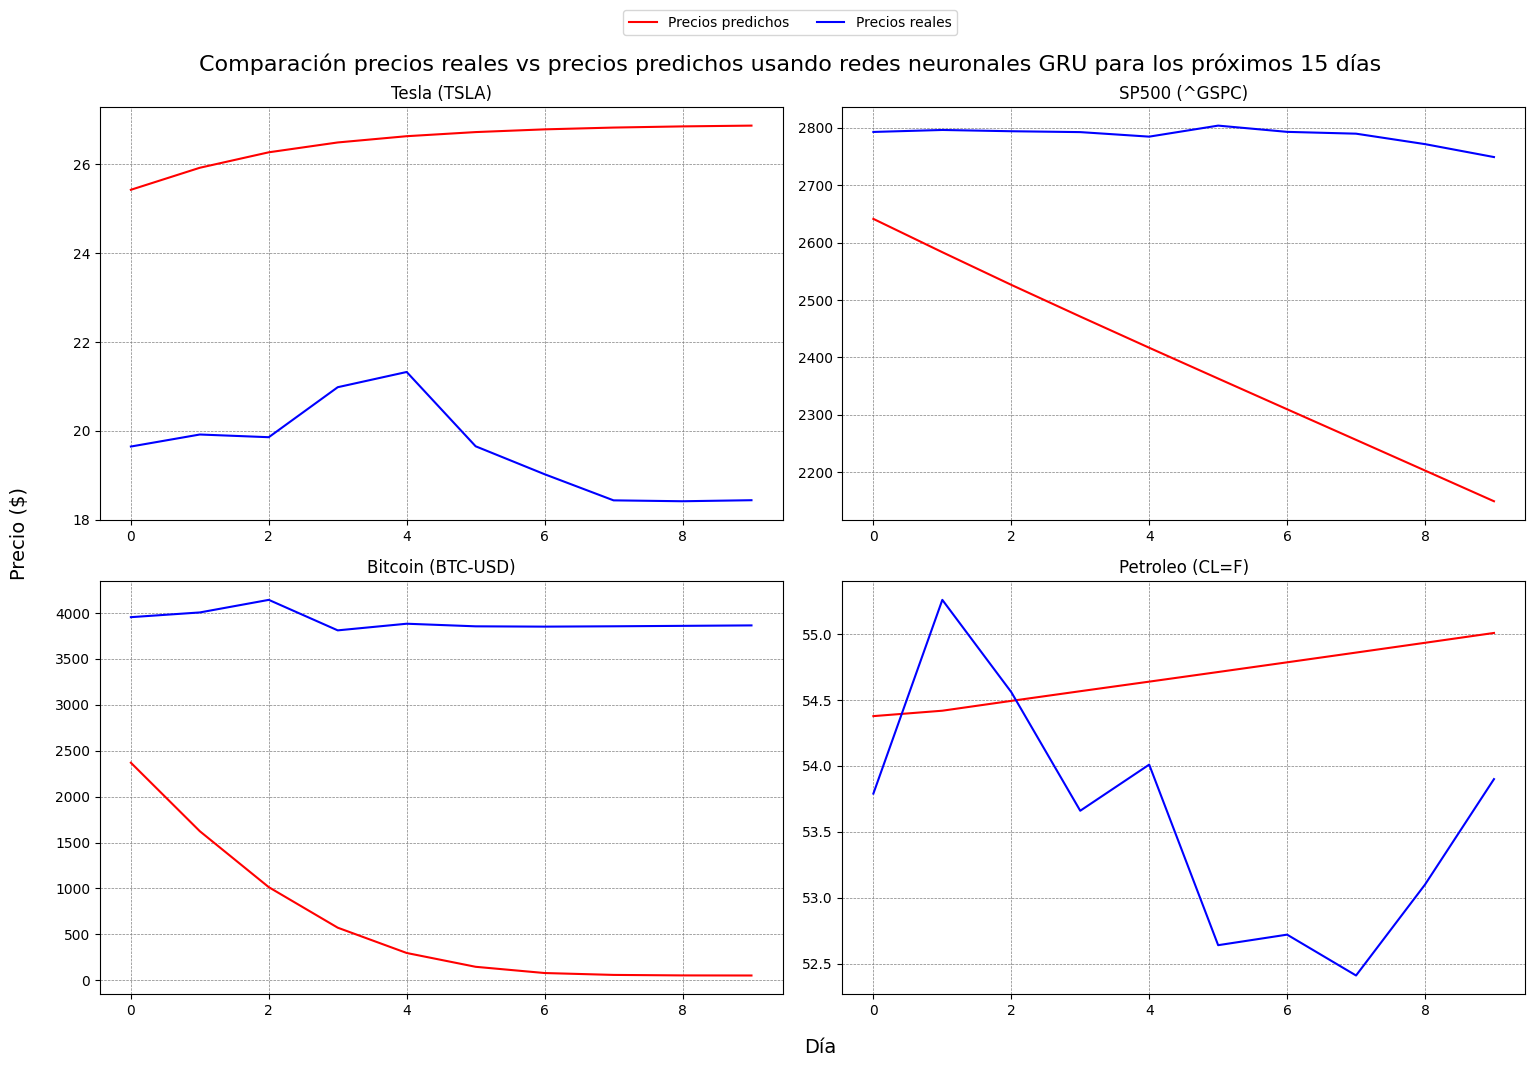

In [41]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM + GRU

In [42]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 35
pasos_sp500 = 35
pasos_bitcoin = 50
pasos_petroleo = 20

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [43]:
def create_lstm_gru(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_petroleo = KerasRegressor(build_fn=create_lstm_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}


grid_search_tesla = GridSearchCV(estimator=lstm_gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_sp500 = GridSearchCV(estimator=lstm_gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_bitcoin = GridSearchCV(estimator=lstm_gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_petroleo = GridSearchCV(estimator=lstm_gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\1638923000.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\1638923000.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_60388\1638923000.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
66/66 [==============================] - 8s 97ms/step - loss: 0.0203
Fitting 3 folds for each of 16 candidates, totalling 48 fits
70/70 [==============================] - 14s 172ms/step - loss: 0.0153
Fitting 3 folds for each of 16 candidates, totalling 48 fits
48/48 [==============================] - 13s 240ms/step - loss: 0.0054
Fitting 3 folds for each of 16 candidates, totalling 48 fits
71/71 [==============================] - 9s 100ms/step - loss: 0.0171
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9892272841355491
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9960101478983662
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.968791263228877
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.985383562915052

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

3/3 [==============================] - 0s 12ms/step
Tesla (TSLA)
RMSE:  5.505964469773037
MSE:  30.315644742403084
MAE:  5.349170684814453
R²:  -35.1357666789621


3/3 [==============================] - 0s 44ms/step
SP500 (^GSPC)
RMSE:  412.7985460243615
MSE:  170402.63959982689
MAE:  399.9504536062047
R²:  -11.887748799452469


4/4 [==============================] - 0s 59ms/step
Bitcoin (BTC-USD)
RMSE:  3636.65274810137
MSE:  13225243.210273247
MAE:  3153.016594696045
R²:  -0.29536851058201097


3/3 [==============================] - 0s 20ms/step
Petroleo (CL=F)
RMSE:  1.0324318454292618
MSE:  1.065915515456471
MAE:  0.7453425271170483
R²:  0.923198444742503




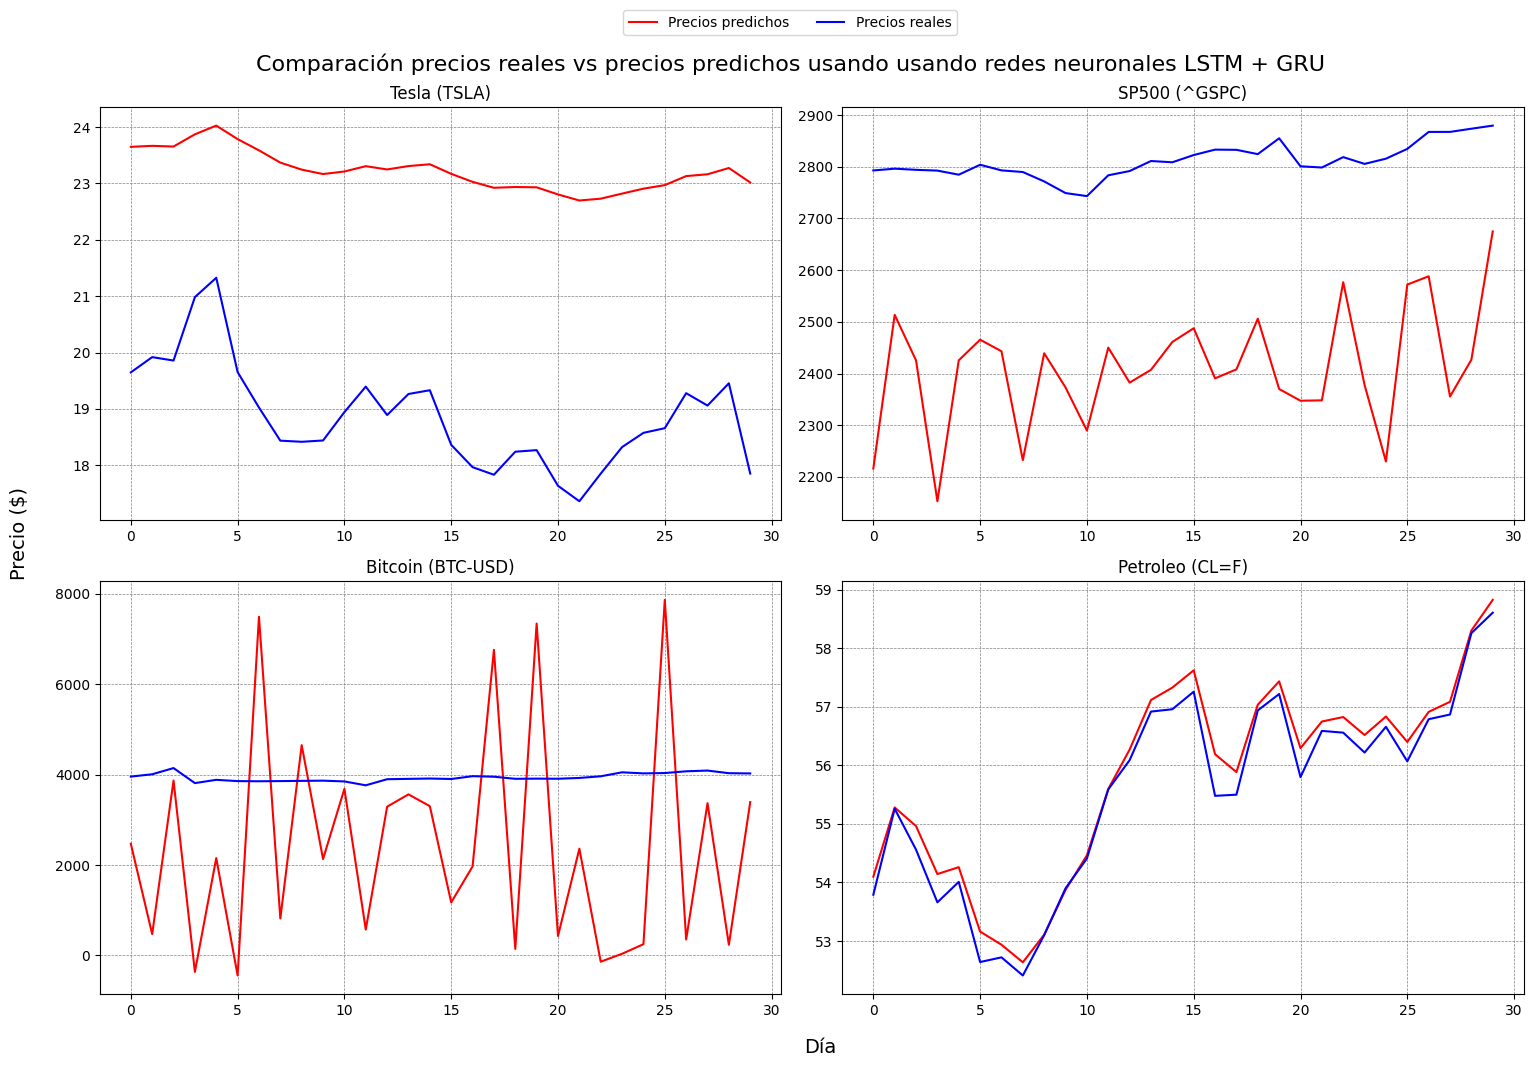

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = Sequential()
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_gru_tesla.add(Dense(units = 1))

lstm_gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_gru_tesla, 'lstm_gru_tesla.h5')

lstm_gru_sp500 = Sequential()
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_gru_sp500.add(Dense(units = 1))
lstm_gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_gru_sp500, 'lstm_gru_sp500.h5')

lstm_gru_bitcoin = Sequential()
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_gru_bitcoin.add(Dense(units = 1))
lstm_gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_gru_bitcoin, 'lstm_gru_bitcoin.h5')


lstm_gru_petroleo = Sequential()
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_gru_petroleo.add(Dense(units = 1))
lstm_gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_gru_petroleo, 'lstm_gru_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  6.598747833407981
MSE:  43.54347296890652
MAE:  6.403655370076497
R²:  -46.761773969727976


SP500 (^GSPC)
RMSE:  2275.763756607133
MSE:  5179100.67588661
MAE:  2176.811325073242
R²:  -10.521131330773194


Bitcoin (BTC-USD)
RMSE:  2825.171732533861
MSE:  7981595.318308379
MAE:  2466.727251688639
R²:  -0.8324602576375402


Petroleo (CL=F)
RMSE:  2.2938677145470088
MSE:  5.2618290918411175
MAE:  1.9927434921264655
R²:  -5.153104014798697




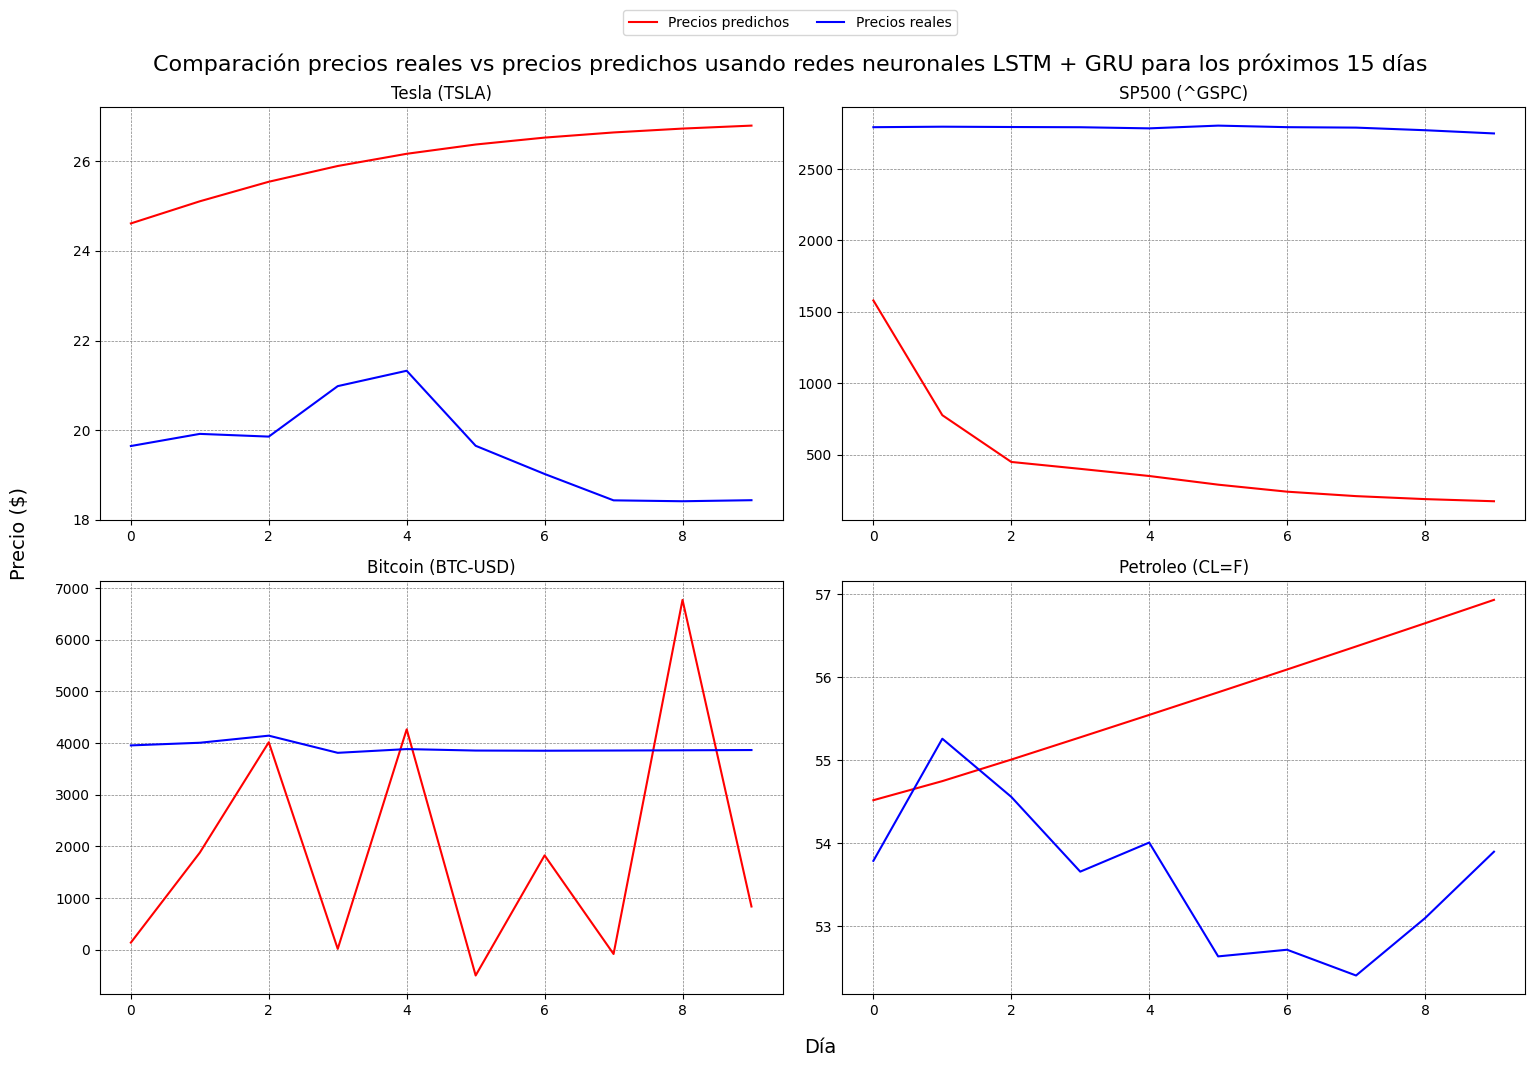

In [45]:
dias = 12

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()